In [306]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 数据操作

## pytorch 和 numpy互转

In [2]:
a = torch.ones(5)
b = a.numpy()
print(a, b)

tensor([1., 1., 1., 1., 1.]) [1. 1. 1. 1. 1.]


In [7]:
a = np.ones(5)
b = torch.tensor(a)
c = torch.from_numpy(a)
print(a, b, c)

[1. 1. 1. 1. 1.] tensor([1., 1., 1., 1., 1.], dtype=torch.float64) tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


## 类型转换

In [14]:
a = torch.randn(2,2).float()
a.dtype

torch.float32

## 设备

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [18]:
a = torch.randn(2,2).float()
a.to(device)

tensor([[0.5989, 0.0499],
        [1.2015, 1.5542]])

## 追踪和动态计算图

*学习需要根据实际情况修正参数
1. 参数做成leaf节点
2. 随便丢一个输入进去 得到各个节点的值
3. 根据模型当前现状计算输出对于每个leaf节点的导数 也即是输出变化1 leaf们应该变化多少
4. 观察当前输出和真实数据的差距 称之为残差 损失 loss res 等等
5. 直接将差距乘以各个leaf节点的导数 修正到leaf值上



*注意容易引起误解的点
1. 输入是一个奇怪的leaf 和参数的leaf有区别
2. 我们一般用差距更新参数leaf 对于输入不需要更新 毕竟下次就另外的输入了


In [175]:
def pretty_print(x):
    print('requires_grad:',x.requires_grad)
    print('grad_fn:      ',x.grad_fn)
    print('grad:         ',x.grad)
#     print('retain_grad:  ',x.retain_grad)
    print('isleaf:       ',x.is_leaf)

### 不追踪默认状况

In [176]:
a = torch.randn(2,2).float()   # 默认不追踪 requires_grad=False
pretty_print(a)

requires_grad: False
grad_fn:       None
grad:          None
isleaf:        True


In [118]:
b = a*2
pretty_print(b)

requires_grad: False
grad_fn:       None
grad:          None
retain_grad:   <bound method Tensor.retain_grad of tensor([[-4.2272, -1.0499],
        [ 4.1371, -4.0701]])>


In [41]:
print(a.is_leaf, b.is_leaf)

True True


### 追踪状况

In [127]:
a1 = torch.randn(2,2,requires_grad=True).float()    # 将a1设置为需要追踪的
pretty_print(a1)

requires_grad: True
grad_fn:       None
grad:          None
retain_grad:   <bound method Tensor.retain_grad of tensor([[ 0.9535, -0.5287],
        [ 0.4039,  0.5433]], requires_grad=True)>


In [180]:
b1 = a1*2  
pretty_print(b1)

requires_grad: True
grad_fn:       <MulBackward0 object at 0x7f37fe72ad30>
grad:          None
isleaf:        False


In [66]:
print(a1.is_leaf, b1.is_leaf)   # b1 是追踪来的 就不叫做leaf了

True False


In [42]:
a1.requires_grad_(False)  # 也可以在a1定义之后再另外修改他的可追踪性

tensor([[1.9885, 0.0079],
        [0.4280, 0.8229]])

### 求出结果对于各个leaf的（偏）导数

In [129]:
L = b1.sum()

In [122]:
L.backward(torch.tensor(10.))   
# 默认参数是torch.tensor(1.) 也即是L变化1 求出各个叶子的变化数字 放进他们的grad属性里面 单位是1 就是导数
pretty_print(a1)
pretty_print(b1)

requires_grad: True
grad_fn:       None
grad:          tensor([[20., 20.],
        [20., 20.]])
retain_grad:   <bound method Tensor.retain_grad of tensor([[1.0479, 0.1739],
        [0.9255, 1.1325]], requires_grad=True)>
requires_grad: True
grad_fn:       <MulBackward0 object at 0x7f37fe79ca60>
grad:          None
retain_grad:   <bound method Tensor.retain_grad of tensor([[2.0959, 0.3477],
        [1.8510, 2.2649]], grad_fn=<MulBackward0>)>


<ipython-input-116-956980fa6401>:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print('grad:         ',x.grad)


In [165]:
L.backward(retain_graph=True) 
# 运行一次 动态计算图就释放了 retain_graph=True 才能多次运行backward
pretty_print(a1)
pretty_print(b1)

requires_grad: True
grad_fn:       None
grad:          tensor([[72., 72.],
        [72., 72.]])
retain_grad:   <bound method Tensor.retain_grad of tensor([[ 0.9535, -0.5287],
        [ 0.4039,  0.5433]], requires_grad=True)>
requires_grad: True
grad_fn:       <MulBackward0 object at 0x7f37fc11c670>
grad:          None
retain_grad:   <bound method Tensor.retain_grad of tensor([[ 1.9069, -1.0575],
        [ 0.8079,  1.0866]], grad_fn=<MulBackward0>)>


<ipython-input-116-956980fa6401>:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print('grad:         ',x.grad)


### 稍微复杂的情况 有输入leaf 有参数leaf

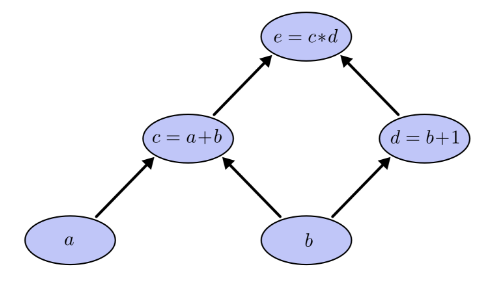

In [238]:
input_a = torch.tensor(2.,requires_grad=True)  
param_b = torch.tensor(10.,requires_grad=True)
output = (input_a+param_b)*(param_b+1)
output

tensor(132., grad_fn=<MulBackward0>)

In [239]:
pretty_print(input_a)
pretty_print(param_b)
pretty_print(output)

requires_grad: True
grad_fn:       None
grad:          None
isleaf:        True
requires_grad: True
grad_fn:       None
grad:          None
isleaf:        True
requires_grad: True
grad_fn:       <MulBackward0 object at 0x7f37fe79c7f0>
grad:          None
isleaf:        False


In [245]:
# 在多次反向传播前 可以清零梯度 或者让梯度就这么累积
# input_a.grad.data.zero_()
input_a.grad.data = torch.tensor(0.)

In [246]:
output.backward(retain_graph=True) 
pretty_print(input_a)
pretty_print(param_b)
pretty_print(output)

requires_grad: True
grad_fn:       None
grad:          tensor(11.)
isleaf:        True
requires_grad: True
grad_fn:       None
grad:          tensor(138.)
isleaf:        True
requires_grad: True
grad_fn:       <MulBackward0 object at 0x7f37fe79c160>
grad:          None
isleaf:        False


1. 改变param_b的数值 可以发现input_a的梯度累积不一样了 
2. 这就是反向传播 我们必须先正向计算一次 才能追踪梯度

## 线性回归模型

### 生成随机数据

In [395]:
delta = torch.randn(1000, 1, dtype=torch.float32)/5
features = torch.randn(1000,1, dtype=torch.float32)
real_w = -1
real_b = 3
labels = real_w*features+real_b + delta

Populating the interactive namespace from numpy and matplotlib


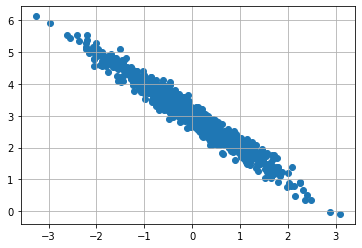

In [396]:
from matplotlib import pyplot as plt
%pylab inline
plt.scatter(features,labels)
# plt.xlim(-8,8)
# plt.ylim(-8,8)
plt.grid()
plt.show()

### 构造数据生成器

In [410]:
import torch.utils.data as Data

batch_size = 20
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

### 构造pytorch网络

In [411]:
class LinearRes(nn.Module):
    def __init__(self):
        super(LinearRes, self).__init__()
        self.linear = nn.Linear(1,1)
    # forward 定义前向传播过程
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearRes()
net

LinearRes(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

### 观察节点参数

In [375]:
for param in net.parameters():
    print(param)   # 参数是瞎初始化的

Parameter containing:
tensor([[0.9809]], requires_grad=True)
Parameter containing:
tensor([0.1219], requires_grad=True)


### 损失函数定义

In [305]:
loss = nn.MSELoss()   # 定义损失函数 偏差 差距 残差 差不多的差

### 优化器定义

In [412]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  
# 随机梯度下降求解器 优化器 这玩意真正地把积累下来的grad更新到leaf上
optimizer       

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

### 典型训练过程

In [316]:
net.linear.weight.is_leaf

True

In [315]:
net.linear.bias

Parameter containing:
tensor([-0.5958], requires_grad=True)

In [413]:
num_epochs = 10
losslist = []
for epoch in range(num_epochs):
    for feature, label in data_iter:
        output = net(feature)
        l = loss(output, label)
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()   实际上optimizer把net吞进去整个处理了一下 相当于包装
        l.backward()          # 各个leaf的grad被更新了 其实主要是net.linear.weight和bias  更新他们的grad属性
        optimizer.step()      # 优化器把leaf上累积的grad修整到leaf的data上
    losslist+=[l.item()]
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 0, loss: 1.793307
epoch 1, loss: 0.206881
epoch 2, loss: 0.044467
epoch 3, loss: 0.036549
epoch 4, loss: 0.043096
epoch 5, loss: 0.035953
epoch 6, loss: 0.035414
epoch 7, loss: 0.052427
epoch 8, loss: 0.056413
epoch 9, loss: 0.036769


Populating the interactive namespace from numpy and matplotlib


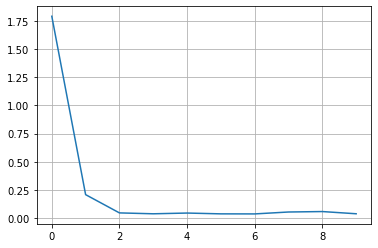

In [414]:
from matplotlib import pyplot as plt
%pylab inline
plt.plot(losslist)
# plt.xlim(-8,8)
# plt.ylim(-8,8)
plt.grid()
plt.show()

In [416]:
for param in net.parameters():
    print(param)   # 经过训练之后 参数和我们预设的参数一样了

Parameter containing:
tensor([[-0.9946]], requires_grad=True)
Parameter containing:
tensor([3.0033], requires_grad=True)
